# Анализ биржевых данных

Источник данных: https://alphavantage.co

---

**Содержание**

- [Подготовка к работе](#Подготовка-к-работе)
    - [Задаем переменные](#Задаем-переменные)
    - [Вспомогательные функции](#Вспомогательные-функции)
- [Базовые характеристики](#Базовые-характеристики)
- [Технический анализ и индикаторы](#Технический-анализ-и-индикаторы)
    - [Линии Боллинджера](#Линии-Боллинджера)
    - [Японские свечи](#Японские-свечи)
- Коррекция цены
    - Дробление акций
    - Дивиденды
    - Пример коррекции по дроблению
    - [Запрос скорректированных данных](#Запрос-скорректированных-данных)
- [Сравнение стоимости](#Сравнение-стоимости)
- Инвестиционный портфель
    - Оценка риска
    - Оценка доходности
    - Формирование портфеля

**Бонус**

- [Криптовалюты](#Криптовалюты)


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_finance import candlestick2_ohlc
import time

In [2]:
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_rows = 10
plt.rc('figure', figsize=(8, 5))

## Подготовка к работе

### Задаем переменные

**Внимание!** Для формирования запросов к Alpha Vantage нужно корректно определить переменную `apikey`. Каждый должен подставить свой собственный ключ.

См. https://www.alphavantage.co/support/#api-key

В переменных и `symbols` и `cryptocur` перечислим активы, которые будет использовать в анализе.

In [3]:
apikey = 'XXXXXXXXXXXXXXXX'
symbols = ['SPY', 'INTC', 'AMD', 'AMZN', 'GOOGL', 'FB', 'AAPL']
crypt_symbols = ['BTC', 'ETH', 'LTC', 'BCH', 'XMR', 'ZEC']

### Вспомогательные функции

Для удобства формирования запросов к Alpha Vantage API оформим их в виде функции `get_alpha_vantage`.  
Функция принимает возвращает объект pandas Dataframe.

Примеры использования:
```python
apple = get_alpha_vantage(apikey, 'AAPL')
intel = get_alpha_vantage(apikey, 'INTC', outputsize='full')
bitcoin = get_alpha_vantage(
            apikey, 'BTC', function='DIGITAL_CURRENCY_DAILY',
            outputsize='compact', market='USD')
```

См. https://www.alphavantage.co/documentation/

In [4]:
def get_alpha_vantage(
        apikey, symbol,
        function='TIME_SERIES_DAILY',
        outputsize='compact',
        datatype='csv',
        **kwargs):

    '''Makes a request with Alpha Vantage API and returns a pandas Dataframe. 

    Usage:
    apple = get_alpha_vantage(apikey, 'AAPL')
    intel = get_alpha_vantage(apikey, 'INTC', outputsize='full')
    bitcoin = get_alpha_vantage(
        apikey, 'BTC', function='DIGITAL_CURRENCY_DAILY',
        outputsize='compact', market='USD')
    
    '''

    base_url = 'https://www.alphavantage.co/query?'
    request_url = base_url + '&'.join\
        (['function=' + function,
          'outputsize=' + outputsize,
          'datatype=' + datatype,
          'symbol=' + symbol,
          'apikey=' + apikey])
    
    for key, val in kwargs.items():
        request_url += '&' + str(key) + '=' + val

    data = pd.read_csv(request_url, index_col='timestamp', parse_dates=True)    
    return data.iloc[::-1]

Продемонстрируем работу этой функции на примере акций Intel (символ INTC).

In [5]:
intel = data = get_alpha_vantage(apikey, 'INTC', outputsize='full')

In [6]:
intel

,open,high,low,close,volume
timestamp,,,,,
1998-01-02,70.69,72.63,70.500,72.63,10231800
1998-01-05,73.06,75.14,72.000,74.50,19592100
1998-01-06,73.88,74.31,72.690,73.13,12078400
1998-01-07,72.75,73.63,71.560,72.75,13845200
1998-01-08,72.25,74.81,72.130,74.31,18932600
...,...,...,...,...,...
2019-02-27,52.76,53.38,52.510,53.24,17590309
2019-02-28,52.92,53.18,52.810,52.96,18388820
2019-03-01,53.44,53.68,52.890,53.30,18359325


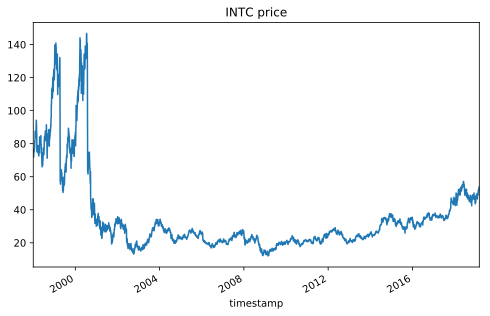

In [7]:
intel['close'].plot(title = '{} price'.format('INTC'))

## Базовые характеристики

Любое исследование временного ряда разумно начать с вычисления среднего значения, среднеквадратического отклонения и скользящих средних.

In [8]:
intel['close'].describe()

count    5326.000000
mean       35.433616
std        24.772228
min        12.080000
25%        21.388125
50%        26.492500
75%        35.477500
max       146.700000
Name: close, dtype: float64

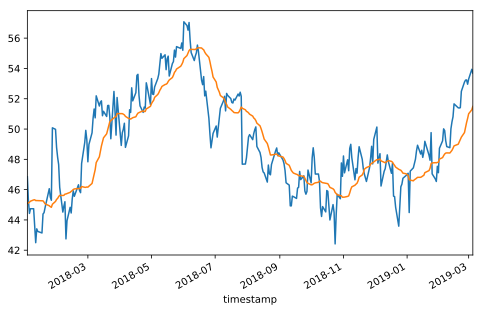

In [9]:
intel['close']['2018':].plot()
intel['close'].rolling(window=20).mean()['2018':].plot()

## Технический анализ и индикаторы

Технический анализ — совокупность инструментов прогнозирования вероятного изменения цен на основе закономерностей изменений цен в прошлом в аналогичных обстоятельствах.

См. [wiki: Технический анализ]( https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%85%D0%BD%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7)

Для выполнения технического анализа используются различные индикаторы - значения, вычисляемые на основе данных о цене. Цель использования индикаторов - получить сигналы для открытия и закрытия сделок.

См. [Список технческих индикаторов](https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/list-of-technical-indicators/)


### Линии Боллинджера

Линии Боллинджера рассчитываются на основе стандартного отклонения от простой скользящей средней. Индикатор помогает оценить, как расположены цены относительно нормального торгового диапазона. Линии Боллинджера создают рамку, в пределах которой цены считаются нормальными. Индикатор строятся в виде верхней и нижней границы вокруг скользящей средней, но ширина полосы не статична, а пропорциональна среднеквадратическому отклонению от скользящей средней за анализируемый период времени.

Торговым сигналом считается, когда цена выходит из торгового коридора — либо поднимаясь выше верхней линии, либо пробивая нижнюю линию. Если график цены колеблется между линиями — индикатор не даёт торговых сигналов.



См. [wiki: Линии Боллинджера](https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B8%D0%B8_%D0%91%D0%BE%D0%BB%D0%BB%D0%B8%D0%BD%D0%B4%D0%B6%D0%B5%D1%80%D0%B0)

Для удобства оформим вычисление стандартного скользящего среднего и линий Боллинджера в виде функции `bollinger_bands`.

Фукция принимает временной ряд (объект pandas Series с индексом из временных меток) и возвращает скользящее среднее, нижнюю и верхную границы в виде временного ряда такой-же размерности.

Примеры использования:

```python
lower_band, sma, upper_band = bollinger_bands(intel['close'])
lower_band, sma, upper_band = bollinger_bands(apple['close'], MA=30, k=3)
```

In [10]:
def bollinger_bands(series, MA=20, k=2):

    '''Takas a pandas timeseries and returns lower_band, sma, upper_band
    as timeseries with the same timestamps.

    Usage:
    lower_band, sma, upper_band = bollinger_bands(intel['close'])
    lower_band, sma, upper_band = bollinger_bands(apple['close'], MA=30, k=3)

    '''

    sma =  series.rolling(window=MA).mean()
    rstd = series.rolling(window=MA).std()
    lower_band = sma - k * rstd
    upper_band = sma + k * rstd
    return lower_band, sma, upper_band

Для удобства в дальнейшей работе, построение наглядного графика с линиями Боллинджера и пространством между ними также оформим в виде отдельной фунции `plot_with_bollinger_bands`.

In [11]:
def plot_with_bollinger_bands(series, color='#0066FF', symbol=''):

    lower_band, sma, upper_band = bollinger_bands(series)

    ax = plt.axes()

    ax.set_title('{} Price and Bollinger Bands'.format(symbol))
    ax.set_xlabel('Date')
    ax.set_ylabel('SMA and Bollinger Bands')

    ax.plot(series.index, series, color=color)

    ax.fill_between(
            series.index, lower_band, upper_band,
            color=color, alpha=0.1)
    ax.plot(
            series.index, lower_band, upper_band,
            color=color, linewidth=1, alpha=0.4)
    ax.plot(series.index, sma,
            color=color, linewidth=1, alpha=0.4)

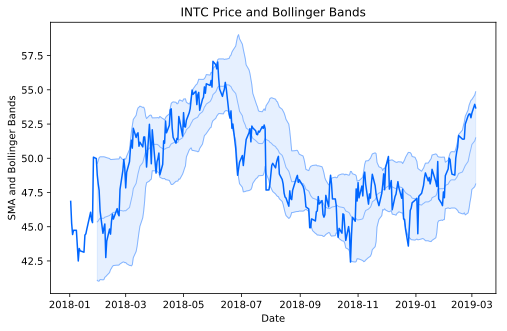

In [12]:
plot_with_bollinger_bands(intel['close']['2018':], symbol='INTC', color='#0066FF')

### Японские свечи

Поскольку на стандартном графике довольно сложно отслеживать сразу несколько величин (open, high, low, close, volume), в техническом анализе используют специальные виды построений. Среди них - японские свечи.

In [13]:
def plot_candlestick(data):

    '''Takes a Dataframe with required columns 'open', 'close', 'high', 'low',
    and makes a candlestick plot.

    '''
    
    ax = plt.axes()
    candlestick2_ohlc(
            ax,
            data['open'], data['high'], data['low'], data['close'],
            width=0.5)

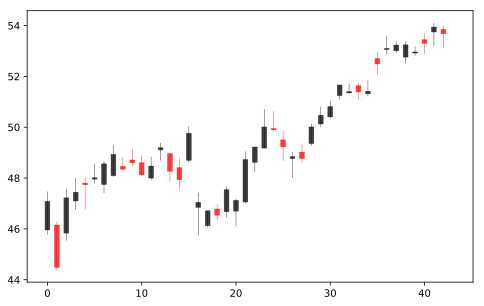

In [14]:
plot_candlestick(intel['2019':])

## Коррекция цены

Рассматривая историю цен акций уместно провести коррекцию цен в соответствии с несколькими дополнительными факторами, в частности:
- выплата дивидендов;
- дробление акций.

### Дробление акций

Рассмотрим данные особенности на примере акций Apple (AAPL).

https://investor.apple.com/investor-relations/faq/default.aspx

> **How many times has Apple's stock split?**  
> Apple’s stock has split four times since the company went public. The stock split on a 7-for-1 basis on June 9, 2014 and split on a 2-for-1 basis on February 28, 2005, June 21, 2000, and June 16, 1987.

Таким образом, становится понятно, что падение цены AAPL в 7 раз с '2014-06-08' на '2014-06-10' не является финансовой катастрофой.

- [wiki: Дробление акций](https://ru.wikipedia.org/wiki/%D0%94%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BA%D1%86%D0%B8%D0%B9)

### Выплата дивидендов

Рассмотрим последние несколько выплат по AAPL.

https://investor.apple.com/investor-relations/financial-information/dividend-history/default.aspx

|   Declared   |    Record    |   Payable    | Amount |     Type     |
|--------------|--------------|--------------|--------|--------------|
| Jan 29, 2019 | Feb 11, 2019 | Feb 14, 2019 | .73   | Regular Cash |
| Nov 1, 2018  | Nov 12, 2018 | Nov 15, 2018 | .73   | Regular Cash |
| Jul 31, 2018 | Aug 13, 2018 | Aug 16, 2018 | .73   | Regular Cash |
| May 1, 2018  | May 14, 2018 | May 17, 2018 | .73   | Regular Cash |
| Feb 1, 2018  | Feb 12, 2018 | Feb 15, 2018 | .63   | Regular Cash |

Можно заметить, что снижение цены акции сразу после выплаты дивидендов на размер выплаты является обоснованным и не указывает на реальную потерю стоимости. 

- [wiki: Дивиденд](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%B2%D0%B8%D0%B4%D0%B5%D0%BD%D0%B4)

### Скорректированная стоимость

Для того, чтобы было проще анализировать стоимость акций с учетом перечисленных выше особенностей, вводится так называемая 'скорректированная стоимось (закрытия)'. Идея получается в том, чтобы получить временной ряд, значения которого компенсируют дробление акций, выплаты дивидендов (и, возможно, другие факторы).

https://www.investopedia.com/terms/a/adjusted_closing_price.asp

### Пример коррекции с учетом деления акций

Попробуем самостоятельно выполнить коррекцию стоимости (закрытия) акций AAPL с учетом предоставленной информации о делениях.

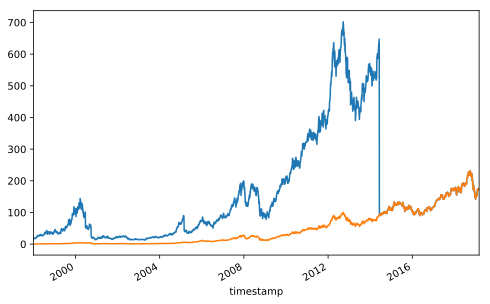

In [15]:
apple = get_alpha_vantage(apikey, 'AAPL', outputsize='full')
apple['close'].plot()

apple = apple.drop(columns=['volume'])
splits = {'2014-06-09': 7, '2005-02-28': 2, '2000-06-21': 2, '1987-06-16': 2}

for date, k in splits.items():
    apple[apple.index < date] /= k

apple['close'].plot()

При этом коррекция с учетом выплаты дивидендов несколько более сложна. Основная идея заключается в вычитании суммы выплаты.

Предположим, что некоторая акция стоит 51 USD перед заявленной выплатой дивидендов в размере 1 USD. Тогда ее справедливая цена составляет 50 USD.

### Запрос скорректированных данных

Вместо дальнейшей "ручной" коррекции, запросим скорректированные данные с Alpha Vargant.

In [16]:
apple_adj = get_alpha_vantage(apikey, 'AAPL', function='TIME_SERIES_DAILY_ADJUSTED', outputsize='full')

In [17]:
apple_adj

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
1998-01-02,13.63,16.25,13.50,16.25,0.5103,6411700,0.0,1.0
1998-01-05,16.50,16.56,15.19,15.88,0.4987,5820300,0.0,1.0
1998-01-06,15.94,20.00,14.75,18.94,0.5948,16182800,0.0,1.0
1998-01-07,18.81,19.00,17.31,17.50,0.5496,9300200,0.0,1.0
1998-01-08,17.44,18.62,16.94,18.19,0.5713,6910900,0.0,1.0
...,...,...,...,...,...,...,...,...
2019-02-27,173.21,175.00,172.73,174.87,174.8700,27835389,0.0,1.0
2019-02-28,174.32,174.91,172.92,173.15,173.1500,28215416,0.0,1.0
2019-03-01,174.28,175.15,172.89,174.97,174.9700,25886167,0.0,1.0


Среди полученных данных очень легко теперь найти записи о делении или о выплатах дивидендов.

In [18]:
apple_adj[apple_adj['split_coefficient'] != 1]

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2000-06-21,50.50,56.94,50.31,55.63,3.4942,4375000,0.0,2.0
2005-02-28,44.68,45.14,43.96,44.86,5.6354,11635900,0.0,2.0
2014-06-09,92.70,93.88,91.75,93.70,86.2085,75414997,0.0,7.0


In [19]:
apple_adj[apple_adj['dividend_amount'] != 0]

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
timestamp,,,,,,,,
2012-08-09,617.850,621.73,617.80,620.7300,78.3099,7915800,2.65,1.0
2012-11-07,573.835,574.54,555.75,558.0019,70.7306,28344600,2.65,1.0
2013-02-07,463.250,470.00,454.12,468.2200,59.6860,25163600,2.65,1.0
2013-05-09,459.810,463.00,455.58,456.7700,58.6152,14231700,3.05,1.0
2013-08-08,463.855,464.10,457.95,461.0100,59.5507,9134900,3.05,1.0
...,...,...,...,...,...,...,...,...
2018-02-09,157.070,157.89,150.24,156.4100,154.0591,66723743,0.63,1.0
2018-05-11,189.490,190.06,187.45,188.5900,186.4744,26212221,0.73,1.0
2018-08-10,207.360,209.10,206.67,207.5300,205.9238,24611202,0.73,1.0


Сравним теперь `adjusted_close` с нашей коррекцией, полученной на определенном этапе. Будем иметь в виду, что мы осуществили коррекцию только по делению и проигнорировали другие факторы.

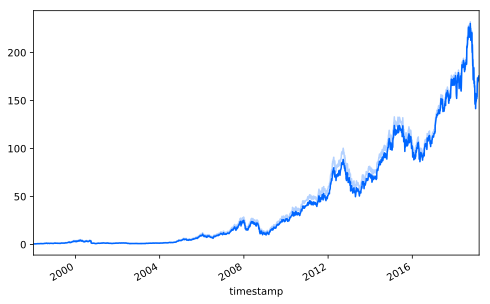

In [20]:
apple['close'].plot(color='#0066FF', alpha=0.3)
apple_adj['adjusted_close'].plot(color='#0066FF')

## Сравнение стоимости

Для сравнительного анализа данных по разным активам запросим больше данных.

**Внимание!** Поскольку API Alpha Vargant имеет ограничение на 5 запросов в минуту, мы вынуждены добавить паузы между запросами.

In [21]:
data_stocks = {}
for symbol in symbols:
    time.sleep(15)
    data_stocks[symbol] = get_alpha_vantage(apikey, symbol)
    print(symbol + ': OK')

SPY: OK
INTC: OK
AMD: OK
AMZN: OK
GOOGL: OK
FB: OK
AAPL: OK


Актив SPY (SPDR S&P 500 ETF) в определенной степени отражает состояние экономики США. Кажется разумным сравнивать стоимость других акций со SPY. 

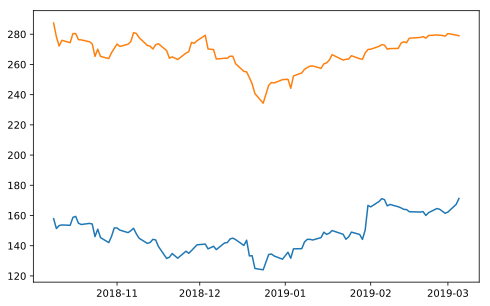

In [22]:
plt.plot(data_stocks['FB'].index,data_stocks['FB']['close'], data_stocks['SPY']['close'])

Как видим, сравнение затруднено существенной разницой в стоимости. Для нивелирования этой разницы будем построим две системы координат на одном рисунке.

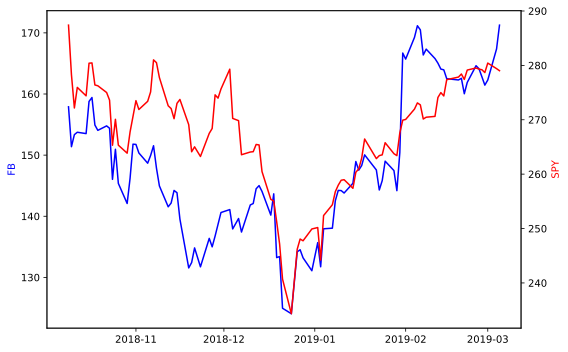

In [23]:
fig, ax1 = plt.subplots()
ax1.plot(data_stocks['FB']['close'], color='b')
ax1.set_ylabel('FB', color='b')
ax2 = ax1.twinx()
ax2.plot(data_stocks['SPY']['close'], color='r')
ax2.set_ylabel('SPY', color='r')

fig.tight_layout()
plt.show()

Здесь уже проще заметить, что в целом изменение цены акций FB коррелирует с общей ситуацией на американсом рынке.

# Бонус

## Криптовалюты 

API Alpha Vargant также предоставляет и многие другие данные. Среди них, например, котировки криптовалют.

In [24]:
bitcoin = get_alpha_vantage(apikey,'BTC',function='DIGITAL_CURRENCY_DAILY',outputsize='full',market='USD')

In [25]:
bitcoin

,open (USD),high (USD),low (USD),close (USD),open (USD).1,high (USD).1,low (USD).1,close (USD).1,volume,market cap (USD)
timestamp,,,,,,,,,,
2014-04-01,468.480106,491.267273,468.480106,479.023434,468.480106,491.267273,468.480106,479.023434,62894.683068,3.012803e+07
2014-04-02,479.679615,494.111337,430.725909,438.377824,479.679615,494.111337,430.725909,438.377824,96314.587552,4.222218e+07
2014-04-03,437.322089,452.441405,414.811104,446.819755,437.322089,452.441405,414.811104,446.819755,74292.749549,3.319547e+07
2014-04-04,448.597144,457.327172,429.184117,451.645992,448.597144,457.327172,429.184117,451.645992,39267.667348,1.773508e+07
2014-04-05,450.027798,466.385470,445.107783,464.379322,450.027798,466.385470,445.107783,464.379322,21574.144537,1.001859e+07
...,...,...,...,...,...,...,...,...,...,...
2019-03-01,3854.708192,3887.576619,3847.455712,3859.794480,3854.708192,3887.576619,3847.455712,3859.794480,108470.834564,4.186751e+08
2019-03-02,3861.095953,3878.130254,3836.400960,3865.239498,3861.095953,3878.130254,3836.400960,3865.239498,109638.095686,4.237775e+08
2019-03-03,3865.535781,3877.438992,3839.018172,3846.075362,3865.535781,3877.438992,3839.018172,3846.075362,104733.257161,4.028120e+08


In [26]:
bitcoin = bitcoin.drop(columns=['open (USD).1', 'high (USD).1', 'low (USD).1', 'close (USD).1'])
bitcoin = bitcoin.rename(index=str, columns={
        'open (USD)': 'open',
        'high (USD)': 'high',
        'low (USD)': 'low',
        'close (USD)': 'close'})

In [27]:
bitcoin

,open,high,low,close,volume,market cap (USD)
timestamp,,,,,,
2014-04-01 00:00:00,468.480106,491.267273,468.480106,479.023434,62894.683068,3.012803e+07
2014-04-02 00:00:00,479.679615,494.111337,430.725909,438.377824,96314.587552,4.222218e+07
2014-04-03 00:00:00,437.322089,452.441405,414.811104,446.819755,74292.749549,3.319547e+07
2014-04-04 00:00:00,448.597144,457.327172,429.184117,451.645992,39267.667348,1.773508e+07
2014-04-05 00:00:00,450.027798,466.385470,445.107783,464.379322,21574.144537,1.001859e+07
...,...,...,...,...,...,...
2019-03-01 00:00:00,3854.708192,3887.576619,3847.455712,3859.794480,108470.834564,4.186751e+08
2019-03-02 00:00:00,3861.095953,3878.130254,3836.400960,3865.239498,109638.095686,4.237775e+08
2019-03-03 00:00:00,3865.535781,3877.438992,3839.018172,3846.075362,104733.257161,4.028120e+08


In [ ]:
crypto_currencies = {}
for symbol in crypt_symbols:
    time.sleep(15)
    crypto_currencies[symbol] = get_alpha_vantage(
            apikey, symbol,
            function='DIGITAL_CURRENCY_DAILY',
            outputsize='compact', market='USD')
    
    crypto_currencies[symbol] = crypto_currencies[symbol].drop(
            columns=[
                'open (USD).1',
                'high (USD).1',
                'low (USD).1',
                'close (USD).1'])

    crypto_currencies[symbol] = crypto_currencies[symbol].rename(
        index=str, columns={
            'open (USD)': 'open',
            'high (USD)': 'high',
            'low (USD)': 'low',
            'close (USD)': 'close'})
    print(symbol + ': OK')

BTC: OK
ETH: OK
LTC: OK
BCH: OK
XMR: OK
